In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras.applications import MobileNetV2

import matplotlib.pyplot as plt

# Завантаження даних

Використаємо image_dataset_from_directory, який автоматично:
- читає картинки;
- присвоює мітки на основі назв папок;
- масштабує картинки;
- створює tf.data.Dataset для тренування.

In [3]:
image_size = (256, 256)
batch_size = 32
data_dir = '../../classification/animal/data/'

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    labels="inferred",
    label_mode="int",
    class_names=['cats', 'dogs', 'snakes'],
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    labels="inferred",
    label_mode="int",
    class_names=['cats', 'dogs', 'snakes'],
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=32
)


Found 3000 files belonging to 3 classes.
Using 2400 files for training.
Found 3000 files belonging to 3 classes.
Using 600 files for validation.


2025-05-14 15:47:23.219442: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-05-14 15:47:23.219473: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-14 15:47:23.219476: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-14 15:47:23.219496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-14 15:47:23.219515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [5]:
X_train, y_train = [], []
for images, labels in train_ds:
    X_train.append(images.numpy())
    y_train.append(labels.numpy())

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

X_val, y_val = [], []
for images, labels in val_ds:
    X_val.append(images.numpy())
    y_val.append(labels.numpy())

X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)


2025-05-14 15:47:28.043783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-14 15:47:29.590409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

X_train: (2400, 256, 256, 3)
y_train: (2400,)
X_val: (600, 256, 256, 3)
y_val: (600,)


In [7]:
train_ds.class_names

['cats', 'dogs', 'snakes']

In [8]:
for images, labels in train_ds.take(1):
    print("Форма images:", images.shape)
    print("Форма labels:", labels.shape)

Форма images: (32, 256, 256, 3)
Форма labels: (32,)


2025-05-14 15:47:41.357779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<!-- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take -->

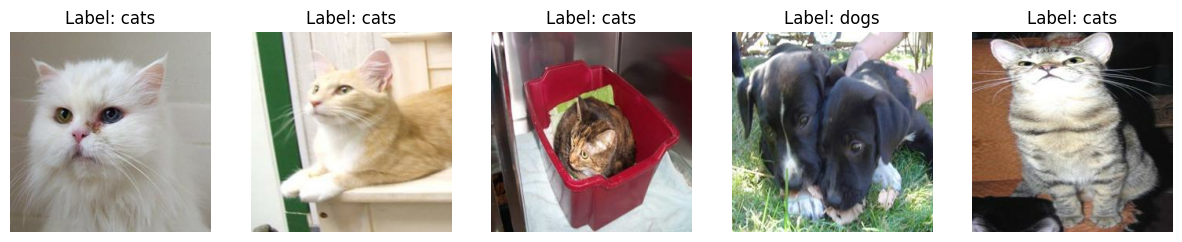

2025-05-14 15:47:44.310193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    
    for i in range(5):
        axes[i].imshow(images[i].numpy().astype("uint8"))
        axes[i].set_title(f"Label: {train_ds.class_names[labels[i].numpy()]}")
        axes[i].axis("off")

    plt.show()  


In [10]:
def show_batch(dataset, class_names, n=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(n * 3, 3))
        for i in range(n):
            ax = plt.subplot(1, n, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = class_names[labels[i]]
            plt.title(label)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

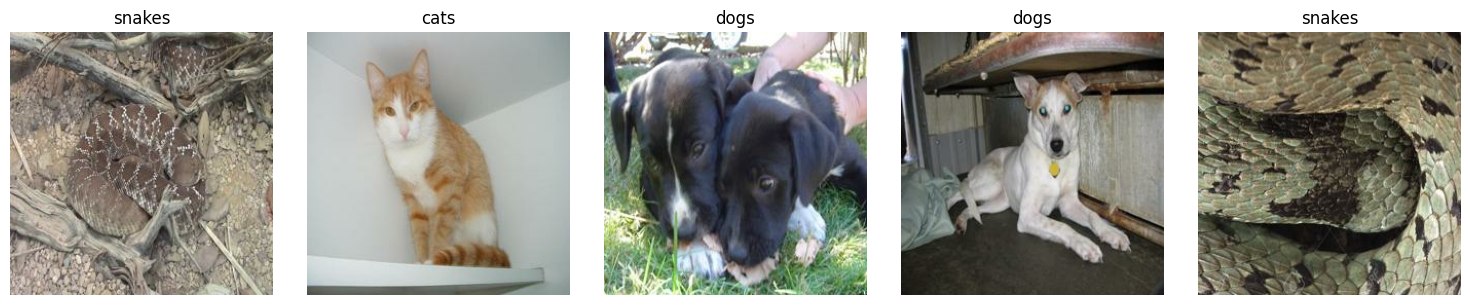

2025-05-14 15:47:52.092565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
show_batch(train_ds, train_ds.class_names, n=5)

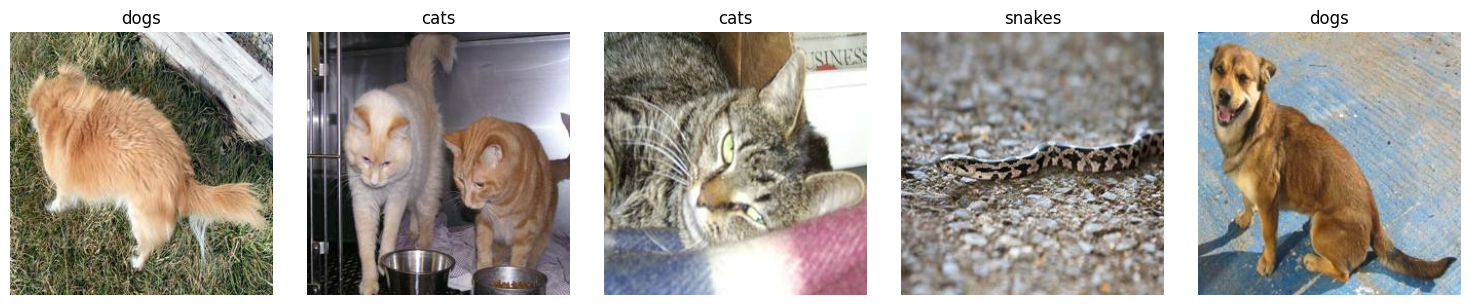

2025-05-14 15:47:57.234098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
show_batch(val_ds, val_ds.class_names, n=5)

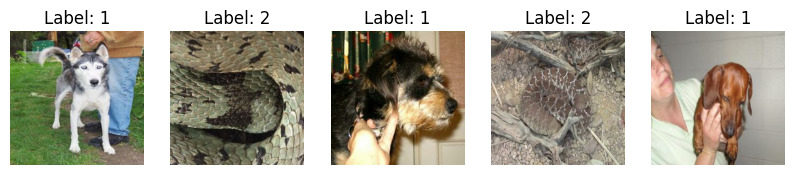

2025-05-14 15:48:03.246219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()


# Попередня обробка

TensorFlow автоматично читає зображення у форматі (batch_size, 224, 224, 3) — це 4D тензор. Пікселі — в діапазоні [0, 255], але моделі краще працюють із нормалізованими значеннями. 

In [14]:
X_train = X_train / 255.0

X_val = X_val / 255.0

In [15]:
X_train

array([[[[0.9098039 , 0.99607843, 0.9843137 ],
         [0.9098039 , 0.99607843, 0.9843137 ],
         [0.9098039 , 0.99607843, 0.9843137 ],
         ...,
         [0.9882353 , 0.99607843, 0.9843137 ],
         [0.9843137 , 0.99215686, 0.98039216],
         [0.9843137 , 0.99215686, 0.98039216]],

        [[0.92156863, 1.        , 0.99215686],
         [0.91764706, 1.        , 0.99215686],
         [0.92156863, 1.        , 0.99215686],
         ...,
         [0.99607843, 1.        , 0.99215686],
         [0.99607843, 1.        , 0.99215686],
         [0.99607843, 1.        , 0.99215686]],

        [[0.93333334, 1.        , 1.        ],
         [0.92941177, 1.        , 1.        ],
         [0.93333334, 1.        , 1.        ],
         ...,
         [0.99607843, 1.        , 0.99215686],
         [0.99607843, 1.        , 0.99215686],
         [0.99607843, 1.        , 0.99215686]],

        ...,

        [[0.49803922, 0.43137255, 0.3137255 ],
         [0.49803922, 0.42352942, 0.29803923]

In [16]:
X_val

array([[[[0.73333335, 0.627451  , 0.5137255 ],
         [0.7411765 , 0.63529414, 0.52156866],
         [0.7294118 , 0.62352943, 0.5058824 ],
         ...,
         [0.5294118 , 0.44313726, 0.34901962],
         [0.5058824 , 0.41960785, 0.3254902 ],
         [0.5568628 , 0.47058824, 0.3764706 ]],

        [[0.7137255 , 0.60784316, 0.49411765],
         [0.6901961 , 0.58431375, 0.47058824],
         [0.67058825, 0.5647059 , 0.44705883],
         ...,
         [0.5764706 , 0.49019608, 0.39607844],
         [0.49803922, 0.4117647 , 0.31764707],
         [0.5137255 , 0.42745098, 0.33333334]],

        [[0.7176471 , 0.6117647 , 0.49803922],
         [0.68235296, 0.5764706 , 0.4627451 ],
         [0.6509804 , 0.54509807, 0.43137255],
         ...,
         [0.6313726 , 0.54509807, 0.4509804 ],
         [0.5019608 , 0.41568628, 0.32156864],
         [0.47843137, 0.39215687, 0.29803923]],

        ...,

        [[0.18039216, 0.15294118, 0.12156863],
         [0.18039216, 0.15294118, 0.12156863]

# Побудова моделі

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(256, 256, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dense(3, activation='softmax')
    tf.keras.layers.Dense(3)

])

/Users/mariiasv/Documents/Project/junior-ds-prep/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Компіляція та тренування

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [20]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),  
    epochs=30,
    callbacks=[early_stop]

)

Epoch 1/30


2025-05-14 15:48:26.257441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.3581 - loss: 204.3242 - val_accuracy: 0.3833 - val_loss: 15.9388
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.4146 - loss: 13.2889 - val_accuracy: 0.3783 - val_loss: 13.8442
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.4535 - loss: 9.9182 - val_accuracy: 0.3567 - val_loss: 23.3983
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.3760 - loss: 17.5518 - val_accuracy: 0.4117 - val_loss: 6.4696
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.4792 - loss: 6.6992 - val_accuracy: 0.3883 - val_loss: 11.7910
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.4692 - loss: 6.3040 - val_accuracy: 0.4133 - val_loss: 7.4017
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.4470 - loss: 7.9393 - val_accuracy: 0.4633 - val_loss: 4.3665
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.4945 - loss: 7.1769 - val_accuracy

In [ ]:
results = model.evaluate(X_val, y_val, verbose=2)
print("Результати:", results)  

loss, accuracy = results
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

In [ ]:
print("Generate predictions for 3 samples")
predictions = model.predict(X_val[:3])
print("predictions shape:", predictions.shape)

In [ ]:
probabilities = tf.nn.softmax(predictions)
print(probabilities.numpy())

In [ ]:
predicted_classes = tf.argmax(predictions, axis=1)
print(predicted_classes.numpy())

In [ ]:
predicted_labels = [train_ds.class_names[i] for i in predicted_classes.numpy()]
print(predicted_labels)


In [ ]:
predicted_labels = [val_ds.class_names[i] for i in predicted_classes.numpy()]
print(predicted_labels)


In [ ]:
import matplotlib.pyplot as plt


for images, labels in val_ds.take(1):
    plt.figure(figsize=(12, 6))  

    for i in range(6): 
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_idx = labels[i].numpy()
        plt.title(f"Label: {val_ds.class_names[label_idx]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),  
    epochs=30,
    callbacks=[early_stop],
    verbose=2
)

In [ ]:
results = model.evaluate(X_val, y_val, verbose=2)
print("Результати:", results)  

loss, accuracy = results
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3)
])


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

In [ ]:
results = model.evaluate(X_val, y_val, verbose=2)
print("Результати:", results)  

loss, accuracy = results
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

In [ ]:
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     'best_model.h5', save_best_only=True, monitor='val_loss'
# )

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    # callbacks=[early_stop, checkpoint]
    callbacks=[early_stop]

)

#  Інференс на нових зображеннях